In [1]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import torch
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import KarateClub
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Loading and Understanding the Dataset

The KarateClub dataset from the torch_geometric.datasets module is a popular network dataset that represents the social network of Zachary's karate club. This dataset is widely used in network science and graph analysis as a classic example for studying social interactions and community detection.

The karate club dataset consists of nodes and edges, where nodes represent members of the karate club, and edges represent social connections or interactions between the members. The dataset is typically used for tasks such as community detection, where the goal is to identify subgroups or communities within the karate club based on the network structure and connections.

In this dataset, there are 34 nodes (club members) and 78 edges (social connections) that capture the interactions among the members of the karate club.

In [3]:
#  Load Zachary's karate club network
dataset = KarateClub()

In [4]:
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Number of features: 34
Number of classes: 4


# Basic Dataset Information
basic information about the dataset, such as the number of features, classes, nodes, edges, average node degree, and checks for isolated nodes, self-loops, and whether the graph is undirected.

In [5]:
data = dataset[0]

In [6]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


# Graph Visualization
- use NetworkX and Matplotlib to visualize the graph.
- the graph's nodes are colored based on their classes (the club's communities), allowing to see how nodes are connected within the community structure.

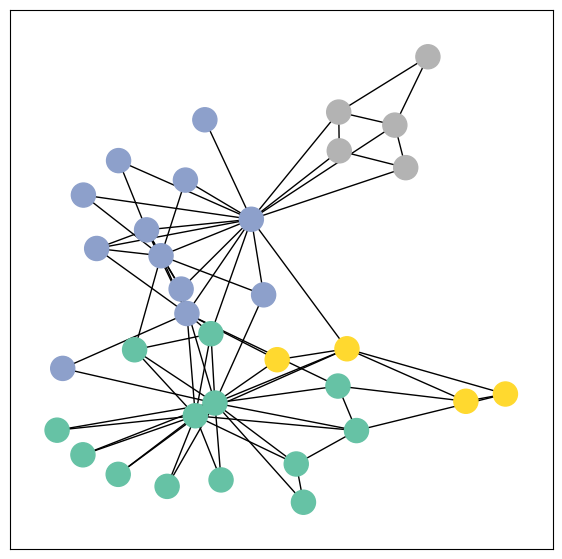

In [7]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(7,7))
plt.xticks([])
plt.yticks([])
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=42),
                 with_labels=False,
                 node_color=data.y,
                 cmap="Set2")
plt.show()

# Model Architecture
- Define the GCN model architecture using PyTorch.
- The model consists of :
  - 2 GCN convolutional layers
  - a linear classifier.

- Use the hyperbolic tangent (tanh) activation functio

In [8]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        out = self.classifier(h)# Apply a final (linear) classifier.

        return out, h

In [9]:
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


# Training the Model:
- define a training loop and train the model for a specified number of epochs (100 in this case).
- use Cross-Entropy Loss and the Adam optimizer. The training loss is recorded during each epoch and plotted at the end of training.

In [10]:
def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

In [11]:
# Lists to store loss and accuracy values
losses = []
accuracies = []
epochs = 100
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# Training loop
for epoch in range(epochs):
    loss, h = train(data)
    losses.append(loss.item())

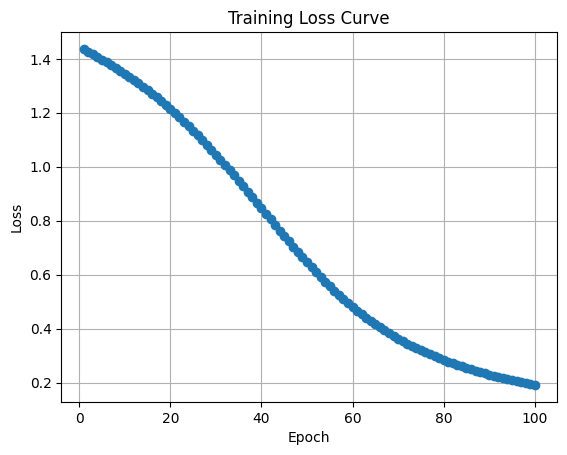

In [12]:
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Visualizing Node Embeddings

- Extract node embeddings from the trained model using the code provided earlier
- Apply t-SNE for dimensionality reduction and create a scatter plot to visualize the embeddings in a 2D space.

<ipython-input-13-d3116166a76c>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='b', cmap='viridis', s=50)


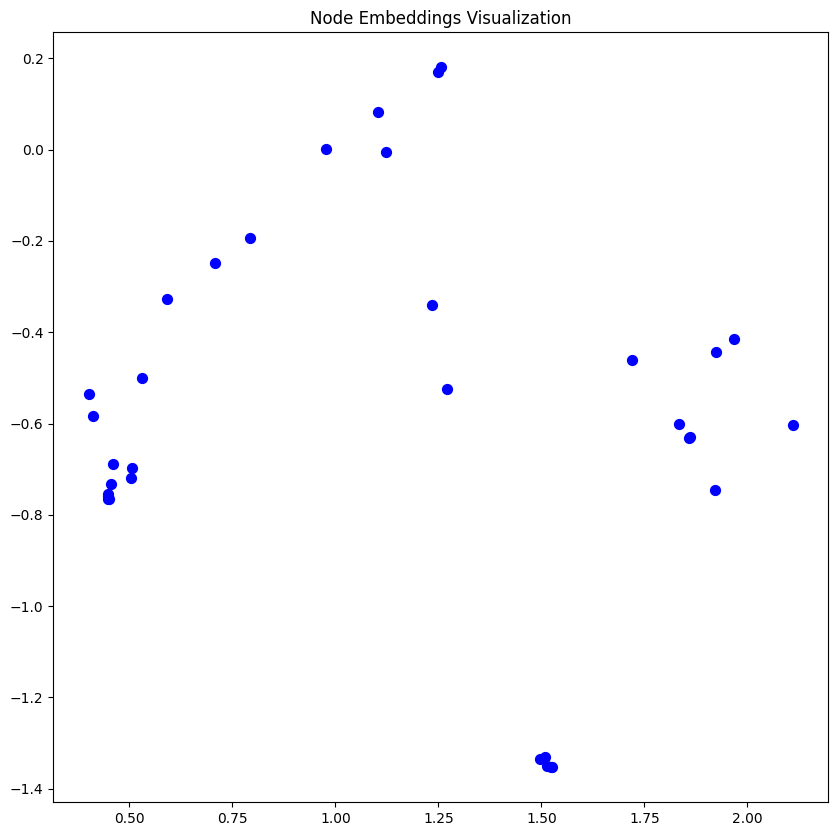

In [13]:
data = dataset[0]
out, embeddings = model(data.x, data.edge_index)

# Convert embeddings to a NumPy array
embeddings = embeddings.detach().numpy()

# Apply dimensionality reduction (e.g., t-SNE) for visualization
reduced_embeddings = TSNE(n_components=2).fit_transform(embeddings)

# Create a scatter plot to visualize the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='b', cmap='viridis', s=50)
plt.title("Node Embeddings Visualization")
plt.show()